<a href="https://colab.research.google.com/github/ayezabashir/Vision-Transformer-Architecture/blob/main/VisionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vision Transformer Architecture**

# **Four Equations**

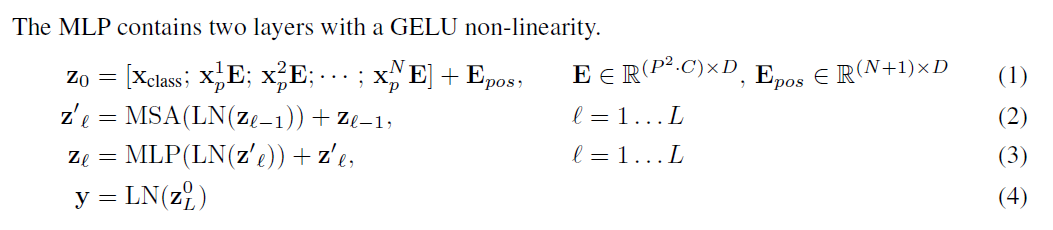

# **Components of Vision Transformer**

#### 1-Images to Patches
#### 2-Embeddings of Patches
#### 3-[class] token
#### 4-Positional Encoding
#### 5-Self Attention
#### 6-Multi Head attention
#### 7-Multi Layer Perceptron
#### 8-Layer Normalization
#### 9-Transformer Encoder
#### 10-Classification Head
#### 11-Vision Transformer

# **Import Important Libraries**

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

## **1. Image to Patches**

**Training resolution is 224**



In [12]:
image = Image.open('dog.jpg').resize((224,224))
x=np.array(image)
P=16
C=3

# making patches
patches= x.reshape(x.shape[0] // P, P,x.shape[1] // P, P, C ).swapaxes(1,2).reshape(-1,P,P,C)
# flattening the patches
x_p= np.reshape(patches,(-1,P*P*C))
N=x_p.shape[0]


## **2- Embeddings of Patches**

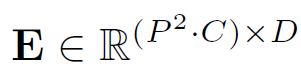

In [13]:
D=768
B=1
x_p=torch.Tensor(x_p)
x_p=x_p[None,...]
E=nn.Parameter(torch.randn(1,P*P*C,D))
patch_embeddings=torch.matmul(x_p,E)
patch_embeddings.shape

torch.Size([1, 196, 768])

## **3- Class Token**

In [14]:
class_token=nn.Parameter(torch.randn(1,1,D))
class_token.shape

torch.Size([1, 1, 768])

In [15]:
patch_embeddings=torch.cat((class_token, patch_embeddings),1)
patch_embeddings.shape

torch.Size([1, 197, 768])

## **4- Positional Encoding**

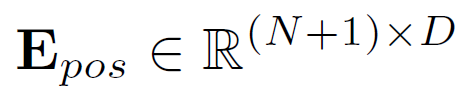

In [16]:
E_pos=nn.Parameter(torch.randn(1,N+1,D))
E_pos.shape

torch.Size([1, 197, 768])

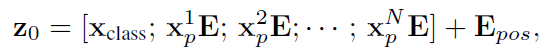

In [17]:
z0=patch_embeddings + E_pos
z0.shape

torch.Size([1, 197, 768])

## **5- Self Attention**

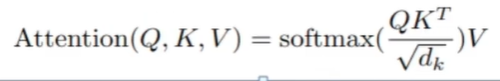

In [18]:
class SelfAttention(nn.Module):
  def __init__(self, embedding_dim=768,key_dim=64):
    super().__init__()
    self.embedding_dim=embedding_dim
    self.key_dim=key_dim
    self.W=nn.Parameter(torch.randn(embedding_dim,3*key_dim))
  def forward(self,x):
    key_dim=self.key_dim
    qkv=torch.matmul(x,self.W)
    q=qkv[:,:,:key_dim]
    k=qkv[:,:,key_dim:2*key_dim]
    v=qkv[:,:,2*key_dim:]
    k_T=torch.transpose(k,-2,-1)
    dot_products=torch.matmul(q,k_T)
    scaled_dot_products=dot_products / np.sqrt(key_dim)
    attention_weights=F.softmax(scaled_dot_products,dim=-1)
    weighted_values=torch.matmul(attention_weights,v)
    return weighted_values

In [19]:
D_h=64
self_attention=SelfAttention(D,D_h)
attention_scores=self_attention(patch_embeddings)
attention_scores.shape

torch.Size([1, 197, 64])

## **6- Multihead Attention**

In [21]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, embedding_dim=768,num_heads=12):
    super().__init__()
    self.embedding_dim=embedding_dim
    self.num_heads=num_heads
    assert embedding_dim % num_heads == 0
    self.key_dim = embedding_dim // num_heads
    self.attention_list=[SelfAttention(embedding_dim, self.key_dim) for _ in range(num_heads)]
    self.multihead_attention=nn.ModuleList(self.attention_list)
    self.W=nn.Parameter(torch.randn(num_heads * self.key_dim, embedding_dim))
  def forward(self, x):
    attention_scores=[attention(x) for attention in self.multihead_attention]
    Z=torch.cat(attention_scores,-1)
    attention_score=torch.matmul(Z,self.W)
    return attention_score

In [22]:
n_head=12
multi_head_attention=MultiHeadSelfAttention(D,n_head)
attention_Score=multi_head_attention(patch_embeddings)
attention_Score.shape

torch.Size([1, 197, 768])